In [1]:
import os
import math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('data/fraudTrain.csv')
df1 = data[data["is_fraud"] == 0].sample(frac=0.20, random_state=42)
df2 = data[data["is_fraud"] == 1]
df = pd.concat([df1, df2])
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
811778,811778,2019-12-07 10:55:06,676173792455,"fraud_Zieme, Bode and Dooley",gas_transport,86.19,Brittany,Cox,F,07177 William Dale Apt. 547,...,34.0287,-118.4924,92043,"Civil engineer, contracting",1961-04-25,f32d1f4b2a918f4c2f6acdc83033ee35,1354877706,33.287851,-118.740970,0
1101718,1101718,2020-04-03 13:10:06,30518206766474,fraud_Lind-Buckridge,entertainment,85.81,Tamara,Martinez,F,471 Marquez Prairie Suite 680,...,36.7154,-89.6287,1019,Aeronautical engineer,1979-01-26,f5dad8e2d7c39d81502d846a20286659,1364994606,36.539950,-89.857416,0
800013,800013,2019-12-04 07:07:04,4658490815480264,fraud_Hackett-Lueilwitz,grocery_pos,99.30,Tara,Richards,F,4879 Cristina Station,...,39.9636,-79.7853,184,Systems developer,1945-11-04,1d023bc78ab93ab65a35bbb53bcc67bd,1354604824,39.582872,-78.838550,0
398945,398945,2019-06-30 18:43:08,4716561796955522,fraud_Lynch-Wisozk,home,42.09,Lauren,Anderson,F,11014 Chad Lake Apt. 573,...,48.2777,-112.8456,743,Water engineer,1972-05-04,dbf6c06d3277438afdf7af883fb4285f,1341081788,48.310513,-112.837535,0
207455,207455,2019-04-15 19:57:49,3528407217576457,fraud_Fisher-Schowalter,shopping_net,4.24,Patricia,Leach,F,71309 Martinez Stravenue,...,36.4715,-82.4834,87124,Warden/ranger,1987-02-14,88814660aba0101b174e1e8137f4a7af,1334519869,37.329094,-82.070746,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265340 entries, 811778 to 1295733
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             265340 non-null  int64  
 1   trans_date_trans_time  265340 non-null  object 
 2   cc_num                 265340 non-null  int64  
 3   merchant               265340 non-null  object 
 4   category               265340 non-null  object 
 5   amt                    265340 non-null  float64
 6   first                  265340 non-null  object 
 7   last                   265340 non-null  object 
 8   gender                 265340 non-null  object 
 9   street                 265340 non-null  object 
 10  city                   265340 non-null  object 
 11  state                  265340 non-null  object 
 12  zip                    265340 non-null  int64  
 13  lat                    265340 non-null  float64
 14  long                   265340 

In [4]:
df["is_fraud"].value_counts()

0    257834
1      7506
Name: is_fraud, dtype: int64

In [5]:
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x: node_id for node_id, x in enumerate(set(df["cc_num"].values.tolist()
                                                          + df["merchant"].values.tolist()))}
    df["from"] = df["cc_num"].apply(lambda x: mapping[x])
    df["to"] = df["merchant"].apply(lambda x: mapping[x])
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from', 'to']).agg({"is_fraud": "sum",
                                                                            "amt": "sum"}).reset_index()
    df["is_fraud"] = df["is_fraud"].apply(lambda x: 1 if x > 0 else 0)

    G = nx.from_edgelist(df[["from", "to"]].values, create_using=graph_type)

    nx.set_node_attributes(G, {x: 1 for x in df["from"].unique()}, "bipartite")
    nx.set_node_attributes(G, {x: 2 for x in df["to"].unique()}, "bipartite")

    nx.set_edge_attributes(G,
                           {(int(x["from"]), int(x["to"])): x["is_fraud"] for idx, x in
                            df[["from", "to", "is_fraud"]].iterrows()},
                           "label")
    nx.set_edge_attributes(G,
                           {(int(x["from"]), int(x["to"])): x["amt"] for idx, x in
                            df[["from", "to", "amt"]].iterrows()},
                           "weight")
    return G

In [6]:
def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x: node_id for node_id, x in enumerate(set(df.index.values.tolist() + df["cc_num"].values.tolist() +
                                                          df["merchant"].values.tolist()))}
    df["in_node"] = df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"] = df["merchant"].apply(lambda x: mapping[x])

    G = nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +
                         [(x["out_node"], mapping[idx])
                          for idx, x in df.iterrows()],
                         create_using=graph_type)

    nx.set_node_attributes(
        G, {x["in_node"]: 1 for idx, x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(
        G, {x["out_node"]: 2 for idx, x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(
        G, {mapping[idx]: 3 for idx, x in df.iterrows()}, "bipartite")

    nx.set_edge_attributes(
        G, {(x["in_node"], mapping[idx]): x["is_fraud"] for idx, x in df.iterrows()}, "label")
    nx.set_edge_attributes(
        G, {(x["out_node"], mapping[idx]): x["is_fraud"] for idx, x in df.iterrows()}, "label")

    nx.set_edge_attributes(G, {(x["in_node"], mapping[idx]): x["amt"]
                           for idx, x in df.iterrows()}, "weight")
    nx.set_edge_attributes(G, {(x["out_node"], mapping[idx]): x["amt"]
                           for idx, x in df.iterrows()}, "weight")
    return G

In [7]:
G_bu = build_graph_bipartite(df, nx.Graph(name='Bipartite Undirected'))

In [8]:
G_bd = build_graph_bipartite(df, nx.DiGraph(name='Bipartite Directed'))

In [9]:
G_tu = build_graph_tripartite(df, nx.Graph(name='Tripartite Undirected'))

In [10]:
G_td = build_graph_tripartite(df, nx.DiGraph(name='Tripartite Directed'))

In [11]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(G_bu)

True

In [12]:
print(nx.info(G_bu))

Graph with 1676 nodes and 201725 edges


C:\Users\NitrousOxide\AppData\Local\Temp\ipykernel_11744\2373338063.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G_bu))


In [13]:
print(nx.info(G_tu))

Graph with 267016 nodes and 530680 edges


C:\Users\NitrousOxide\AppData\Local\Temp\ipykernel_11744\2867625765.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G_tu))


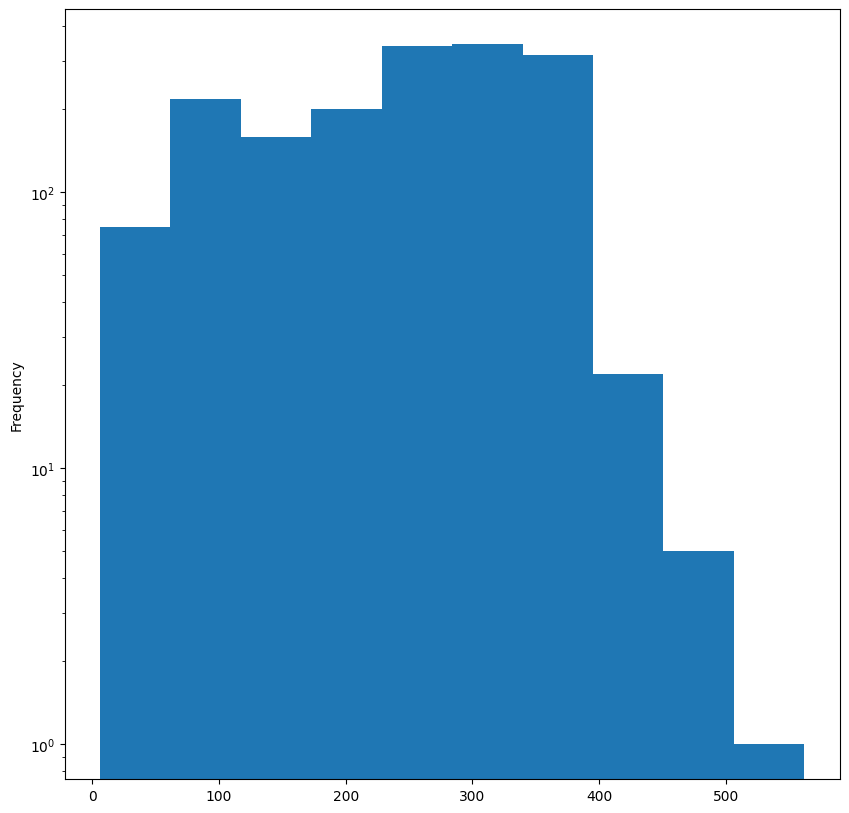

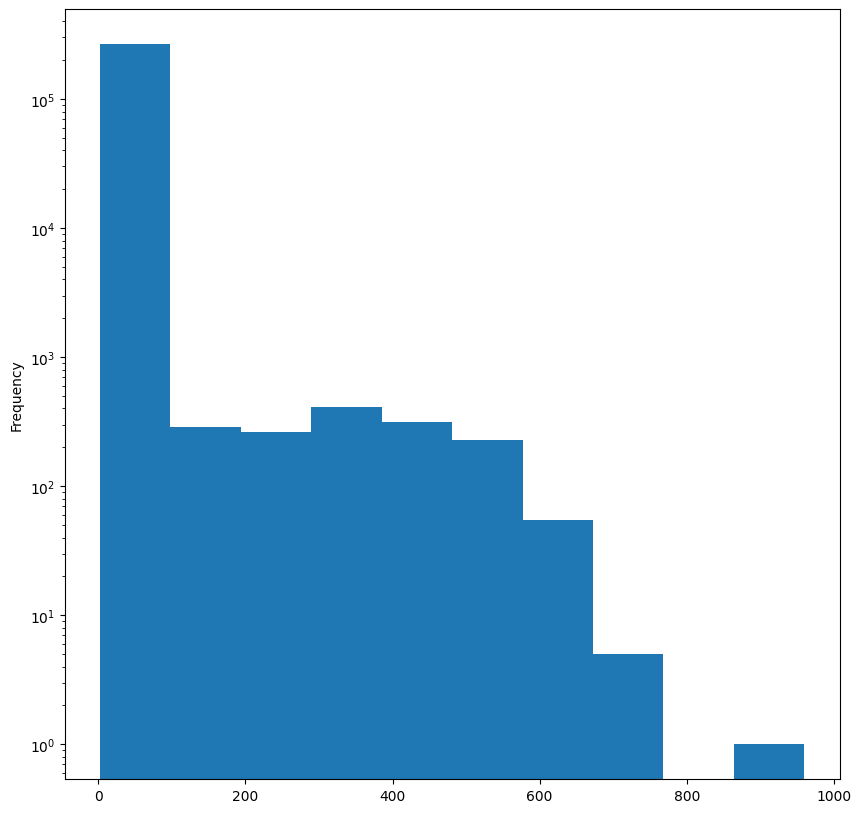

In [14]:
for G in [G_bu, G_tu]:
    plt.figure(figsize=(10, 10))
    degrees = pd.Series(
        {
            k: v for k, v in nx.degree(G)
        }
    )
    degrees.plot.hist()
    plt.yscale("log")

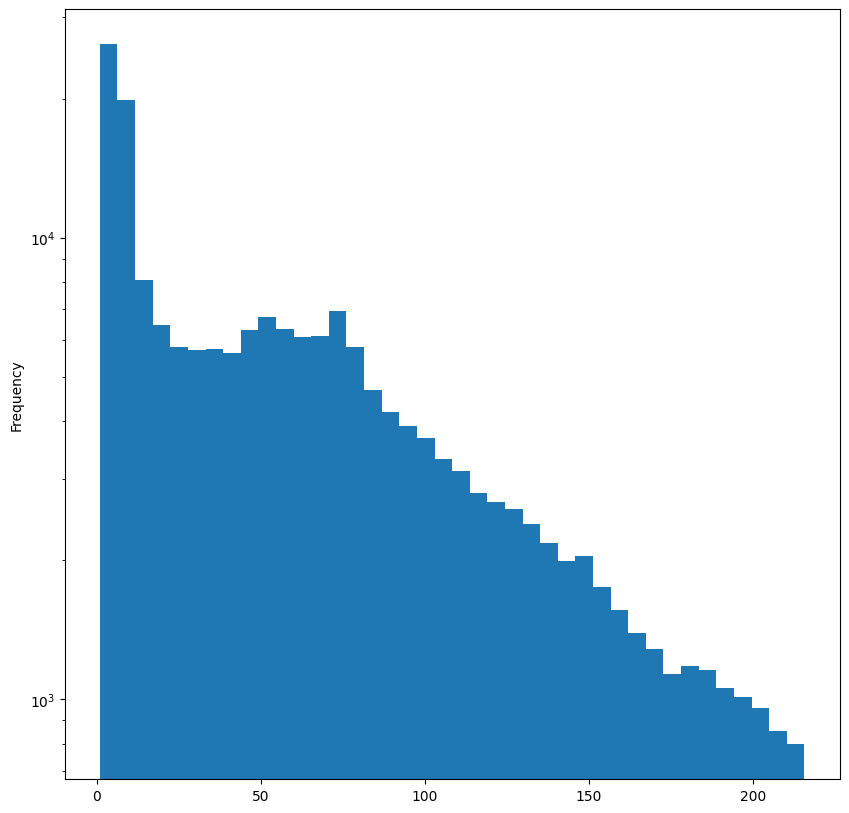

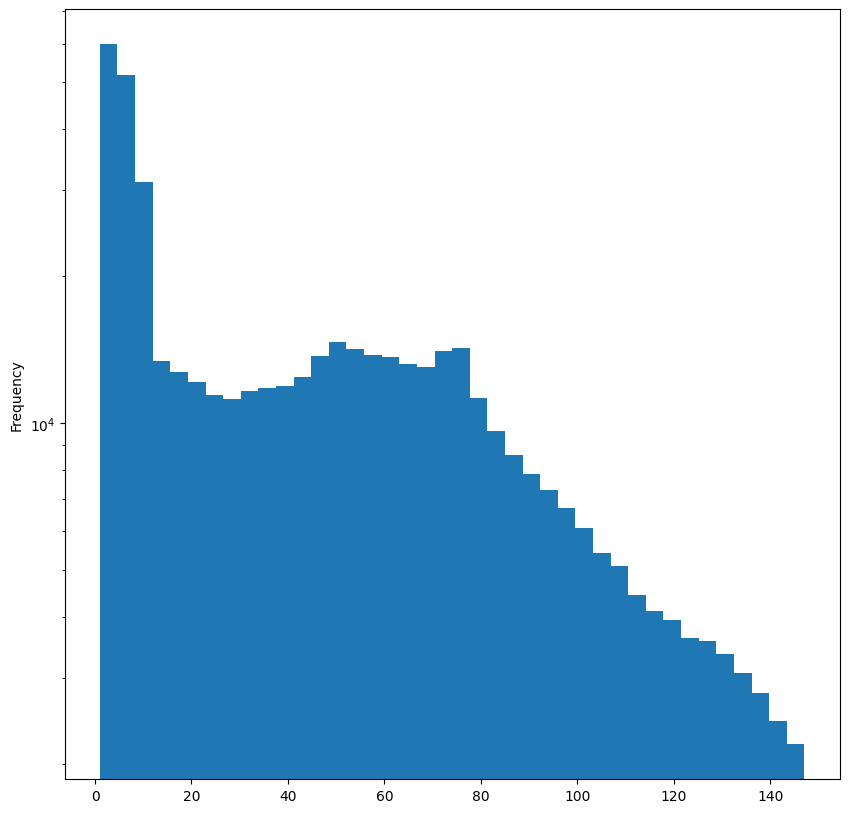

In [15]:
for G in [G_bu, G_tu]:
    allEdgesWeights = pd.Series(
        {(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True)})
    np.quantile(allEdgesWeights.values, [0.10, 0.50, 0.70, 0.9, 1.0])
    quant_dist = np.quantile(allEdgesWeights.values, [0.10, 0.50, 0.70, 0.9])
    allEdgesWeightsFiltered = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True)
                                         if d[2]["weight"] < quant_dist[-1]})
    plt.figure(figsize=(10, 10))

    allEdgesWeightsFiltered.plot.hist(bins=40)
    plt.yscale("log")

In [16]:
import scipy as sp
import scipy.stats
nx.degree_pearson_correlation_coefficient(G_bu)

-0.13774320410492813

In [17]:
nx.degree_pearson_correlation_coefficient(G_tu)

-0.8079472914861103

In [18]:
import community
parts = community.best_partition(G_bu, random_state=42, weight='weight')
communities = pd.Series(parts)
print(communities.value_counts().sort_values(ascending=False))

6     325
12    181
9     155
0     137
2     130
10    121
15     84
4      80
3      77
5      72
8      69
1      66
11     62
13     57
7      46
14     14
dtype: int64


<AxesSubplot: ylabel='Frequency'>

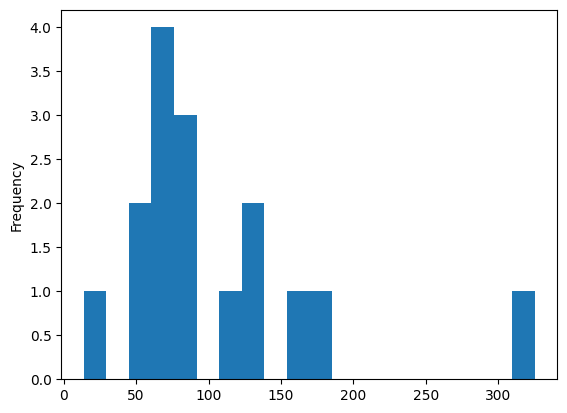

In [19]:
communities.value_counts().plot.hist(bins=20)

In [20]:
graphs = []
d = {}
for x in communities.unique():
    tmp = nx.subgraph(G_bu, communities[communities == x].index)
    fraud_edges = sum(nx.get_edge_attributes(tmp, "label").values())
    ratio = 0 if fraud_edges == 0 else (
        fraud_edges / tmp.number_of_edges()) * 100
    d[x] = ratio
    graphs += [tmp]
    
pd.Series(d).sort_values(ascending=False)

14    29.166667
2     18.146341
1     15.384615
5     15.000000
8     14.606742
0     13.888889
15    11.652174
7     11.111111
13    11.014493
11    10.674157
3     10.000000
4      9.405941
9      8.688946
10     6.298003
12     5.501181
6      1.390386
dtype: float64

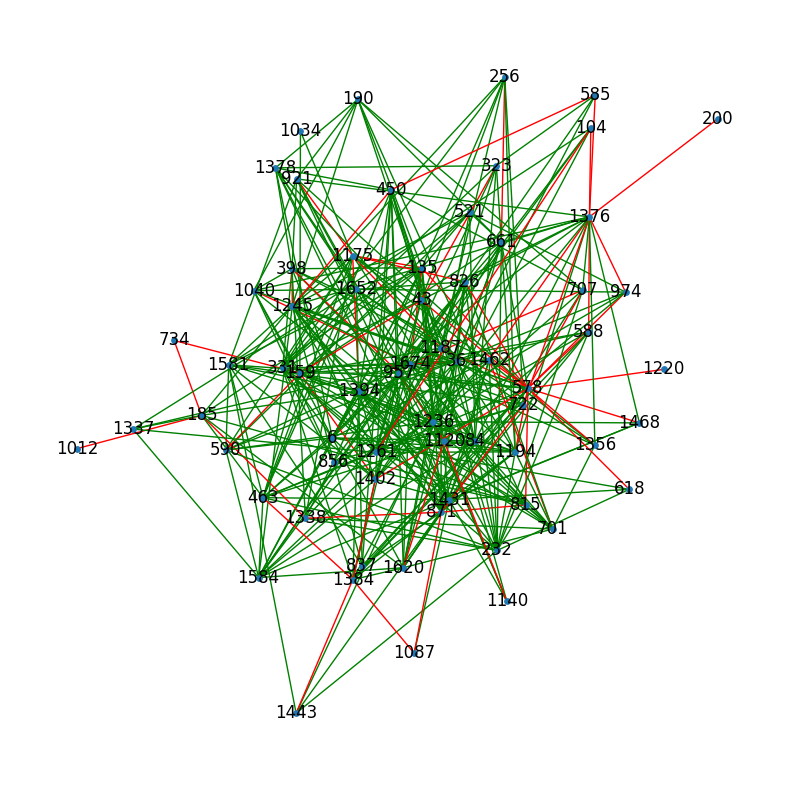

In [21]:
gId = 1  # можно менять для разных сообществ
plt.figure(figsize=(10, 10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(
    graphs[gId], 'label').values()]
nx.draw_networkx(graphs[gId], pos=spring_pos,
                 edge_color=edge_colors, with_labels=True, node_size=15)
plt.show()

In [22]:
from sklearn.utils import resample
df_majority = df[df.is_fraud == 0]
df_minority = df[df.is_fraud == 1]

df_maj_downsampled = resample(df_majority,
                             n_samples=len(df_minority),
                             random_state=42)

df_downsampled = pd.concat([df_minority, df_maj_downsampled])

print(df_downsampled.is_fraud.value_counts())
G_down = build_graph_bipartite(df_downsampled)

1    7506
0    7506
Name: is_fraud, dtype: int64


In [23]:
from sklearn.model_selection import train_test_split

train_edges, test_edges, train_labels, test_labels = train_test_split(list(range(len(G_down.edges))),
                                                                      list(nx.get_edge_attributes(G_down,
                                                                                                  "label").values()),
                                                                      test_size=0.20, random_state=42)

In [24]:
edgs = list(G_down.edges)
train_graph = G_down.edge_subgraph([edgs[x] for x in train_edges]).copy()
train_graph.add_nodes_from(list(set(G_down.nodes) - set(train_graph.nodes)))

In [25]:
from node2vec import Node2Vec # pip install node2vec, pip install python-Levenshtein
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder
node2vec_train = Node2Vec(train_graph, weight_key='weight')
model_train = node2vec_train.fit(window=10)

J:\Опять работа\Sem9\Теория принятия решений и распознавания образов\2022laba1\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.54it/s]


In [26]:
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
for cl in classes:
    embeddings_train = cl(keyed_vectors=model_train.wv)
    train_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
    test_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]

    rf = RandomForestClassifier(n_estimators=1000, random_state=42)
    rf.fit(train_embeddings, train_labels)

    y_pred = rf.predict(test_embeddings)
    print(cl)
    print('Precision:', metrics.precision_score(test_labels, y_pred))
    print('Recall:', metrics.recall_score(test_labels, y_pred))
    print('F1-Score:', metrics.f1_score(test_labels, y_pred))

<class 'node2vec.edges.HadamardEmbedder'>
Precision: 0.5531914893617021
Recall: 0.035326086956521736
F1-Score: 0.06641123882503193
<class 'node2vec.edges.AverageEmbedder'>
Precision: 0.7068381855111713
Recall: 0.7092391304347826
F1-Score: 0.7080366225839269
<class 'node2vec.edges.WeightedL1Embedder'>
Precision: 0.543859649122807
Recall: 0.021059782608695652
F1-Score: 0.040549378678875085
<class 'node2vec.edges.WeightedL2Embedder'>
Precision: 0.532258064516129
Recall: 0.022418478260869564
F1-Score: 0.04302477183833116


In [27]:
nod2vec_unsup = Node2Vec(G_down, weight_key='weight')
unsup_vals = nod2vec_unsup.fit(window=10)

from sklearn.cluster import KMeans

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
true_labels = [x for x in nx.get_edge_attributes(G_down, "label").values()]

for cl in classes:
    embedding_edge = cl(keyed_vectors=unsup_vals.wv)

    embedding = [embedding_edge[str(x[0]), str(x[1])] for x in G_down.edges()]
    kmeans = KMeans(2, random_state=42).fit(embedding)

    nmi = metrics.adjusted_mutual_info_score(true_labels, kmeans.labels_)
    ho = metrics.homogeneity_score(true_labels, kmeans.labels_)
    co = metrics.completeness_score(true_labels, kmeans.labels_)
    vmeasure = metrics.v_measure_score(true_labels, kmeans.labels_)

    print(cl)
    print('NMI:', nmi)
    print('Homogeneity:', ho)
    print('Completeness:', co)
    print('V-Measure:', vmeasure)

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.40it/s]


<class 'node2vec.edges.HadamardEmbedder'>
NMI: 0.00268839727123941
Homogeneity: 0.002577665855169119
Completeness: 0.002925832155662906
V-Measure: 0.002740736030344436
<class 'node2vec.edges.AverageEmbedder'>
NMI: 0.09296082807871979
Homogeneity: 0.08923194045479424
Completeness: 0.09711665682818593
V-Measure: 0.09300749096706894
<class 'node2vec.edges.WeightedL1Embedder'>
NMI: 0.20552647094557544
Homogeneity: 0.20557368073419433
Completeness: 0.2055576829144293
V-Measure: 0.20556568151306065
<class 'node2vec.edges.WeightedL2Embedder'>
NMI: 0.1701859081905459
Homogeneity: 0.1696042592188445
Completeness: 0.17085436092101314
V-Measure: 0.17022701499767434
